In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from utils.model import load_bird_list, import_dataset
from scipy.signal import savgol_filter
import os
import pickle
import yaml

with open('config.yaml', 'r') as file: # load yaml config
    CONFIG = yaml.safe_load(file)


In [2]:
bird_list_index, num_class = load_bird_list() # load WABAD species list
x_train, y_train, x_val, y_val, x_test, y_test, samples_df_train, birdnet_scores_train,  wabad_train_set_size, esc50_set_size = import_dataset(bird_list_index) # load train, val and test set


In [3]:
# load train labels and sampling data (sampling with EPS_SKEW was performed a 2nd time with an other range (min/max)
with open(os.path.join(CONFIG["results_path"],"results_sampling_evaluation_all.pkl"), "rb") as file:
    loaded_data1 = pickle.load(file)
with open(os.path.join(CONFIG["results_path"],"results_sampling_evaluation_EPS.pkl"), "rb") as file:
    loaded_data2 = pickle.load(file)

param_thresholds_list = np.concatenate((loaded_data1[0], loaded_data2[0],), axis=0)
param_names = param_thresholds_list[:,0]
param_signs = np.array( [int(numeric_string) for numeric_string in param_thresholds_list[:,1]] )
param_values = np.array( [float(numeric_string) for numeric_string in param_thresholds_list[:,2]])

#param_thresholds_list = np.reshape(param_thresholds_list, (5000,14))
mAP_list = np.concatenate((loaded_data1[1], loaded_data2[1]), axis=0)
cmAP_list = np.concatenate((loaded_data1[2], loaded_data2[2]), axis=0)
class_AP_list = np.concatenate((loaded_data1[3], loaded_data2[3]), axis=0)
SAMPLING_PARAMETERS = loaded_data1[6]
SAMPLING_PARAMETERS_SIGN = loaded_data1[7]

#baseline given by the pretrained model birdNET
pretrained_mAP = 0.511
pretrained_cmAP = 0.367

# load baseline results 500 samples with random sampling and bird_prop = 0.10
with open(os.path.join( CONFIG["results_path"], "results_500_random_samples.pkl" ), "rb") as file:
    random_data = pickle.load(file)
random_mAP_list = random_data[1]
random_cmAP_list = random_data[2]
random_cmAP_mean = np.mean(random_cmAP_list)
random_cmAP_std = np.std(random_cmAP_list)


print(SAMPLING_PARAMETERS)
print(SAMPLING_PARAMETERS_SIGN)

['BirdNETmax', 'Entropy_mean', 'Entropy_max', 'AEI', 'BI', 'LEQf', 'nROI', 'TFSD', 'MEANf', 'EAS', 'EPS_SKEW', 'ACI', 'NDSI', 'BirdNETmax', 'Entropy_mean', 'Entropy_max', 'AEI', 'BI', 'LEQf', 'nROI', 'TFSD', 'MEANf', 'EAS', 'EPS_SKEW', 'ACI', 'NDSI']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


In [4]:
# Runing average to plot mean and std of point cloud
def running_average(xdata, ydata, num_points, window_size):
    data_range = np.max(xdata)-np.min(xdata)
    window_size = window_size*data_range
    x_vec= np.linspace(np.min(xdata), np.max(xdata),  num_points)

    x_mean = []
    y_mean = []
    y_std = []

    for i in range(np.shape(x_vec)[0]):
        xl = x_vec[i]-window_size/2
        xh = x_vec[i]+window_size/2
        select = np.logical_and(xdata >= xl, xdata <= xh) 
        x_mean.append((xl+xh)/2)
        y_mean.append(np.mean(ydata[select]))
        y_std.append(np.std(ydata[select]))

    x_mean = np.array(x_mean)
    y_mean = np.array(y_mean)
    y_std = np.array(y_std)

    y_mean = savgol_filter(y_mean, int(num_points/2), 6) # window size 51, polynomial order 3
    y_std = savgol_filter(y_std, int(num_points/2), 6) # window size 51, polynomial order 3

    return x_mean, y_mean, y_std

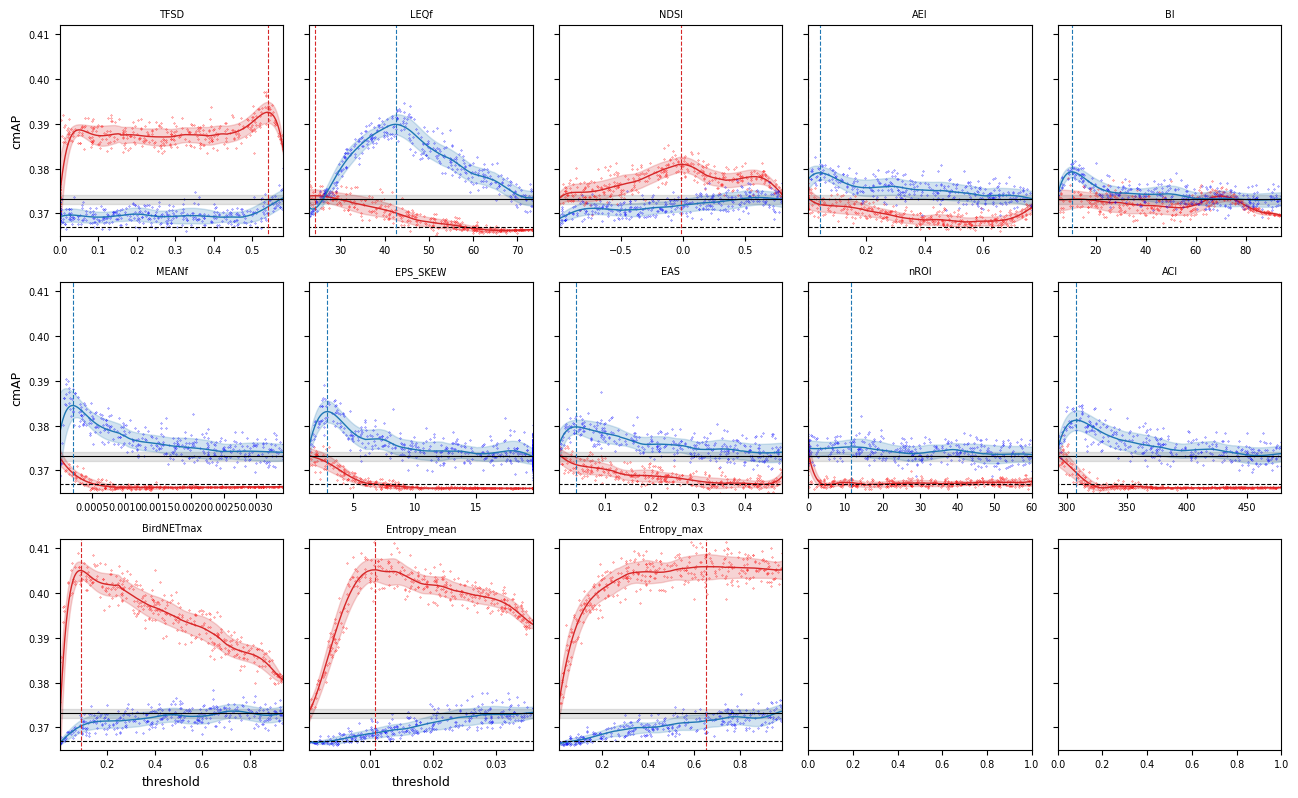

In [5]:
#Plot paramaters
SMALL_SIZE = 7
MEDIUM_SIZE = 9
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

px = 1/plt.rcParams['figure.dpi']  # pixel in inches

# plot order of sampling parameters
parameters_plot = ['TFSD', 'LEQf', 'NDSI', 'AEI', 'BI', 'MEANf', 'EPS_SKEW' , 'EAS',  'nROI', "ACI", "BirdNETmax", "Entropy_mean", "Entropy_max"]

#run running_average parameters:
filter_window_size = 0.05
num_points = 500

#fig, ax = plt.subplots(3, 5, figsize=(800*px, 550*px), sharey=True)
fig, ax = plt.subplots(3, 5, figsize=(13, 8), sharey=True)

ax = ax.flatten()


ylim1, ylim2 = [0.365, 0.412]


thresh_opt_cmAP = dict()
opt_cmAP = dict()


x_lim_min_list = []
x_lim_max_list = []

N=len(parameters_plot)

for i in range(0,N):

    parameter = parameters_plot[i]
    idx_select = (param_names == parameter) & (param_signs == 1)
    param_max = np.max(param_values[idx_select])
    param_min = np.min(param_values[idx_select])
    x_reg = np.linspace(param_min, param_max, 200)

    x_lim_max = param_max

    param_select = param_values[idx_select]
    cmAP_select = cmAP_list[idx_select]
    ax[i].plot(param_values[idx_select], cmAP_list[idx_select], 'r.', label ="low thresh", markersize=0.5)

    x_mean, y_mean, y_std = running_average( param_values[idx_select], cmAP_list[idx_select], num_points, filter_window_size)
    ax[i].plot(x_mean, y_mean, color="tab:red", linewidth=1, alpha=1, label = f"{parameter} > threshold")
    ax[i].fill_between(x_mean, y_mean-y_std,y_mean+y_std , alpha=0.2, color="tab:red")

    lt_opt = x_mean[np.argmax(y_mean)]
    l_max_cmap =  np.max(y_mean)
    l_max_std = y_std[np.argmax(y_mean)]

    idx_select = (param_names == parameter) & (param_signs == -1)
    param_max = np.max(param_values[idx_select])
    param_min = np.min(param_values[idx_select])
    x_lim_min = param_min

    x_reg = np.linspace(param_min, param_max, 200)

    param_select = param_values[idx_select]
    cmAP_select = cmAP_list[idx_select]
    ax[i].plot(param_values[idx_select], cmAP_list[idx_select], 'b.', label ="high thresh", markersize=0.5)

    x_mean, y_mean, y_std = running_average( param_values[idx_select], cmAP_list[idx_select], 500, filter_window_size)
    ax[i].plot(x_mean, y_mean, color="tab:blue", linewidth=1, alpha=1, label = f"{parameter} < threshold")
    ax[i].fill_between(x_mean, y_mean-y_std,y_mean+y_std , alpha=0.2, color="tab:blue")


    ht_opt = x_mean[np.argmax(y_mean)]
    h_max_cmap = np.max(y_mean)
    h_max_std = y_std[np.argmax(y_mean)]


    thresh_opt_cmAP[parameter] = [lt_opt, ht_opt]
    opt_cmAP[parameter] = [l_max_cmap, l_max_std,  h_max_cmap, h_max_std]

    idx_select = (param_names == parameter)
    param_max = np.max(param_values[idx_select])
    param_min = np.min(param_values[idx_select])
    range_l = np.min(samples_df_train[parameter])
    range_h = np.max(samples_df_train[parameter])
    range_order = range_h-range_l
    xlim1 = range_l-0.05*range_order
    xlim2= range_h +0.05*range_order
    ax[i].set_xlim([x_lim_min, x_lim_max])

    x_lim_min_list.append(float(x_lim_min))
    x_lim_max_list.append(float(x_lim_max))


    ax[i].set_ylim([ylim1, ylim2])

    ax[i].set_title(f"{parameter}")
    ax[i].hlines(y=pretrained_cmAP, xmin=param_min, xmax=param_max, linewidth=0.8, color='k', linestyle='dashed')

    ax[i].fill_between([-500,500], random_cmAP_mean-random_cmAP_std/2,random_cmAP_mean+random_cmAP_std/2 , alpha=0.1, color="k")
    ax[i].hlines(y=random_cmAP_mean, xmin=param_min, xmax=param_max, linewidth=0.8, color='k')




ax[-4].set_xlabel("threshold")
ax[-5].set_xlabel("threshold")
ax[0].set_ylabel('cmAP')
ax[5].set_ylabel('cmAP')


for i in range(0,N):
    parameter = parameters_plot[i]
    
    ax[i].vlines( np.array(thresh_opt_cmAP[parameter][0]) ,0,10000,color="tab:red",   linestyle='dashed',linewidth=0.8)
    ax[i].vlines( np.array(thresh_opt_cmAP[parameter][1]) ,0,10000, color="tab:blue",  linestyle='dashed',linewidth=0.8)

plt.tight_layout()

